# Algorithm: SVM
Acknowledgement: Most of the code was referenced from Prof. Mafas Raheem's AML lab-8.
## Model Validation Strategy
Three models evaluated with two different datasets as described below.
### Standard data (without oversampling)
- Base,
- Grid-Search-CV,
- Random-Search-CV
### Oversampling data (class balancing)
- Base,
- Grid-Search-CV,
- Random-Search-CV
### Conclusion (for all evaluations)
- confusion matrix
- accuracy chart

In [ ]:
import warnings
from collections import Counter
from importlib import reload

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import models.uci_heart_disease_dataset as uci
import custom_libs.classification_lib as clib
import models.global_data as gd

# Disabled warning.
# warnings.filterwarnings("ignore")

In [16]:
# Load the preprocessed dataset (299 records; with 14 features) from `processed.cleveland-preprocessed`.
data = pd.read_csv(uci.UCIHeartDiseaseDataFile.cleveland_preprocessed, names = uci.get_standard_features())
print(f'Data shape: {data.shape}.')
data.head(3)

Data shape: (299, 14).


,Age,Gender,Chest Pain,BP Systolic,Cholesterol,Blood Sugar,Rest ECG,Exe. Max Heartrate,Exe. Induced Angina,Exe. ST Depression,Exe. ST Segment Slope,Major Vessels,Thalassemia,Target
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286.0,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229.0,0,2,129,1,2.6,2,2,7,1


## Evaluation with Standard Dataset (without oversampling)
Standard dataset is the preprocessed data with 299 records and 14 columns.

### Data
Prepare features and target variables from preprocessed dataset.

Class count before and after split (stratified).
Entire-set  : Counter({0: 160, 1: 139}).
Train-set   : Counter({0: 128, 1: 111}).
Test-set    : Counter({0: 32, 1: 28}).


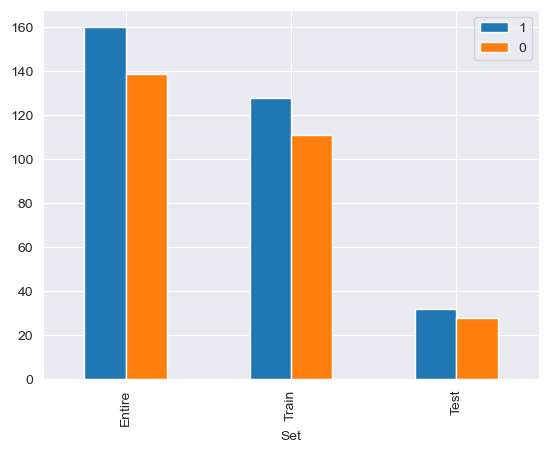

In [17]:
reload(gd)
# Drop target variable from X set.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
# Assign target variable into y set.
y = data[uci.UCIHeartDiseaseData.target]

# Display the counter for '1' and '0' in y set before splitting.
print('Class count before and after split (stratified).')
print(f'Entire-set  : {Counter(y)}.')

# Global variables are used for splitting in order to achieve seamless evaluation result.
# test_size = 0.2, stratify = True and random_state = 1.
x_train, x_test, y_train, y_test = clib.scale_and_split(X,
                                                        y,
                                                        gd.DataSplitStrategy.test_size,
                                                        gd.DataSplitStrategy.stratify,
                                                        gd.DataSplitStrategy.random_state)

print(f'Train-set   : {Counter(y_train)}.')
print(f'Test-set    : {Counter(y_test)}.')

clib.get_class_counters(y, y_train, y_test).set_index('Set').plot.bar();

### Base Model

In [ ]:
reload(ev)
# A function to build a base model.
def build_and_validate_base_model(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    # Train the model with training set.
    # Without the random-state, DT is producing different result despite the random-state in sample split for training-set.
    dc= DecisionTreeClassifier(random_state=ev.random_state)
    dc.fit(x_train, y_train)

    # Display the best hyperparameters used.
    print(f'Params         :{ dc.get_params()}.')

    # Do prediction with the trained model.
    y_pred = dc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve.
    ev.display_validation_report(y_test, y_pred, x_test, dc, test_name)

### Grid Search CV (Function)

In [ ]:
reload(ev)
# A function discover the model's best hyperparameters and perform cross-validation using GridSearchCV.
def build_and_validate_with_grid_search_cv(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Build Grid-search with parameters and stratified k fold strategy for cross-validation.
    grid_scv = GridSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's best hyperparameters for optimal performance.
    grid_scv.fit(x_train,y_train)

    # Display the best hyperparameters and score. The best score is mean of CV scores for train-set.
    print(f'Best params          :{grid_scv.best_params_}.')
    print(f'Best score (*mean)   :{grid_scv.best_score_}.')

    # Predict using the trained model on the test-set.
    y_pred = grid_scv.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve.
    ev.display_validation_report(y_test, y_pred, x_test, grid_scv, test_name)

### Random Search CV (Function)

In [ ]:
reload(ev)
# A function discover the model's best hyperparameters and perform cross-validation using RandomSearchCV.
def build_and_validate_with_random_search_cv(x_set, y_set, test_name):
    print(f'\nEvaluation name: {test_name}.')

    # Calls the evaluation helper module to scale features and do split (classes are balanced using stratify split).
    x_train, x_test, y_train, y_test = ev.scale_and_split(x_set, y_set)

    dt= DecisionTreeClassifier(random_state=ev.random_state)

    # Train and discover the model's best hyperparameters for optimal performance.
    rand_svc = RandomizedSearchCV(dt, parameters, scoring='accuracy', cv=skfolds)

    # Train and discover the model's hyperparameters for optimal result.
    rand_svc.fit(x_train,y_train)

    # Display the best hyperparameters and score.
    print(f'Best params :{rand_svc.best_params_}.')
    print(f'Best score  :{rand_svc.best_score_}.')

    # Predict using the trained model.
    y_pred = rand_svc.predict(x_test)

    # Calls the evaluation helper module to display classification-report, confusion-matrix and ROC curve
    ev.display_validation_report(y_test, y_pred, x_test, rand_svc, test_name)

## Evaluation with Standard Dataset (without oversampling)
`processed.cleveland-preprocessed` - standard dataset is the preprocessed data with 299 records and 14 columns.

### Data Preparation

In [ ]:
reload(ev)
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

print(f'Classes before split: {Counter(y)}.')

x_train, x_test, y_train, y_test = ev.scale_and_split(X, y)
print(f'Classes after split (train): {Counter(y_train)}.')
print(f'Classes after split (test): {Counter(y_test)}.')



In [ ]:
# Evaluation: Standard data with base model
reload(ev)
build_and_validate_base_model(X, y, ev.EvaluationType.std_base)

In [ ]:
# Evaluation: Standard data with Grid Search CV
build_and_validate_with_grid_search_cv(X, y, ev.EvaluationType.std_grid_search_cv)

In [ ]:
# Evaluation: Standard Random Search CV
build_and_validate_with_random_search_cv(X, y, ev.EvaluationType.std_random_search_cv)

In [ ]:
print(ev.accuracies)

## Evaluation with Oversampling Dataset (Class balancing)

### Data Preparation and Oversampling

In [ ]:
# Prepare features and target variables.
X = data.drop(uci.UCIHeartDiseaseData.target, axis=1)
y = data[uci.UCIHeartDiseaseData.target]

# Perform over-sampling with SMOTE
X_b, y_b = SMOTE().fit_resample(X, y)
print(f'Classes before oversampling :{Counter(data[uci.UCIHeartDiseaseData.target])}.')
print(f'Classes after oversampling  :{Counter(y_b)}.')

In [ ]:
# Before over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=data[uci.UCIHeartDiseaseData.target])

# After over-sampling
plt.subplots(figsize=(5,5))
sns.countplot(x=y_b)

In [ ]:
# Evaluation: Over-sampled Base
build_and_validate_base_model(X_b, y_b, ev.EvaluationType.os_base)

In [ ]:
# Evaluation: Over-sampled Grid Search CV
build_and_validate_with_grid_search_cv(X_b, y_b, ev.EvaluationType.os_grid_search_cv)

In [ ]:
# Evaluation: Over-sampled Random Search CV
build_and_validate_with_random_search_cv(X_b, y_b, ev.EvaluationType.os_random_search_cv)

In [ ]:
print(ev.accuracies)

## Conclusion

In [ ]:
plt.bar(range(len(ev.accuracies)), list(ev.accuracies.values()), align='center')
plt.xticks(range(len(ev.accuracies)), list(ev.accuracies.keys()))

plt.show()

In [ ]:
### Register the highest in global
ev.global_accuracies['DT'] = 87